In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot

from sklearn import feature_extraction
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from sklearn.cluster import KMeans

In [2]:
import requests
from zipfile import ZipFile
from io import BytesIO

## load the big loan data
loan_data_path = [f"https://github.com/aaubs/ds-master/raw/main/data/assignments_datasets/KIVA/kiva_loans_part_{i}.csv.zip" for i in range(3)]
rs = [requests.get(path) for path in loan_data_path]
files = [ZipFile(BytesIO(r.content)) for r in rs]
loan_data = []
i = 0 
for f in files:
    loan_data.append(pd.read_csv(f.open(f"kiva_loans_part_{i}.csv")))
    i += 1

## concat all parts of kiva_loan_data
data_kvloans = pd.concat(loan_data)

# Change the datatype of datetype column
data_kvloans['year']  = pd.to_datetime(data_kvloans['date']).dt.year.astype(str)

In [3]:
# Using mpi from OPHI. Mpi data from kiva is prone to be missing or inaccuracte.
# https://www.kaggle.com/marcomarchetti/ophi-subnat-decomp-headcount-mpi-201718/data

data_mpi = pd.read_csv('OPHI_SubNational_Decomposition_HeadCount_MPI_2017-18.csv', index_col = None, nrows =993, encoding = 'latin1', usecols = ['ISO_Country_Code', 'Country', 'Sub_national_region', 'World_region', 'Survey', 'Year', 'Population_Share', 'Country_MPI', 'Region_MPI', 'Schooling', 'Child_school_attendance', 'Child_mortality ', 'Nutrition', 'Electricity', 'Improved_sanitation', 'Drinking_water', 'Floor', 'Cooking _fuel', 'Asset_ownership', 'Num_of_indic', 'Indic_missing'])

In [4]:
data_kvmpi = pd.read_csv("https://raw.githubusercontent.com/aaubs/ds-master/refs/heads/main/data/assignments_datasets/KIVA/kiva_mpi_region_locations.csv")
data_kvmpi.dropna(axis= 0, thresh = 2, inplace = True)

In [5]:
# Import GDP per capita data from World bank
# https://www.kaggle.com/datasets/tmishinev/world-country-gdp-19602021

data_gdp = pd.read_csv('world_country_gdp_usd.csv')
data_gdp['year'] = data_gdp['year'].astype(str)
data_gdp.set_index(['country','year'], inplace = True)

In [6]:
df = data_kvloans[ [ 'loan_amount', 'activity', 'sector', 'use', 'country_code', 'country', 'region', 'term_in_months', 'borrower_genders', 'repayment_interval','year'] ]

In [7]:
# Add GDP into the dataframe

df = pd.concat( [df, pd.DataFrame(columns = ['GDP_per_capita_USD'],index = df.index, data = [ np.nan ] * len(df) ) ], axis = 1, join = 'outer' )

for country, year in data_gdp.reset_index()[[ 'country', 'year' ]].values:
    df.loc[(df['country'] == country) & (df['year'] == year), 'GDP_per_capita_USD'] = data_gdp.loc[ country, year ]['GDP_per_capita_USD']

In [8]:
# Clean the data
df.dropna(subset=['borrower_genders','GDP_per_capita_USD'], inplace=True)

In [9]:
print(df.shape) 
print(df['loan_amount'].shape) 
print(df['GDP_per_capita_USD'].shape) 

(640843, 12)
(640843,)
(640843,)


In [10]:
df['Loan amount / GDP per capita (%)'] = 100* df['loan_amount'] / df['GDP_per_capita_USD']

In [11]:
# Add MPI country into the dataframe

df = pd.concat( [df, pd.DataFrame(columns = ['MPI country'],index = df.index, data = [ np.nan ] * len(df) ) ], axis = 1, join = 'outer' )
for country in data_mpi[ 'Country'].unique().tolist():
    df.loc[ (df['country'] == country) , 'MPI country'] = data_mpi.loc[  (data_mpi['Country'] == country) , 'Country_MPI' ].unique()[0]

In [12]:
df.head(5)

,loan_amount,activity,sector,use,country_code,country,region,term_in_months,borrower_genders,repayment_interval,year,GDP_per_capita_USD,Loan amount / GDP per capita (%),MPI country
0,300.0,Fruits & Vegetables,Food,"To buy seasonal, fresh fruits to sell.",PK,Pakistan,Lahore,12.0,female,irregular,2014,1251.175719,23.977447,0.23
1,575.0,Rickshaw,Transportation,to repair and maintain the auto rickshaw used ...,PK,Pakistan,Lahore,11.0,"female, female",irregular,2014,1251.175719,45.956774,0.23
2,150.0,Transportation,Transportation,To repair their old cycle-van and buy another ...,IN,India,Maynaguri,43.0,female,bullet,2014,1573.885642,9.530553,NaN
3,200.0,Embroidery,Arts,to purchase an embroidery machine and a variet...,PK,Pakistan,Lahore,11.0,female,irregular,2014,1251.175719,15.984965,0.23
4,400.0,Milk Sales,Food,to purchase one buffalo.,PK,Pakistan,Abdul Hakeem,14.0,female,monthly,2014,1251.175719,31.969930,0.23


In [13]:
# Label the sectors, repayment_interval, borrower_genders

labels_sector = preprocessing.LabelEncoder()
labels_sector.fit( df['sector'].unique().tolist() )
df.loc[:,'sector label'] = labels_sector.transform( df['sector'] )

labels_repayment = preprocessing.LabelEncoder()
labels_repayment.fit( df['repayment_interval'].unique().tolist() )
df.loc[:,'repayment interval label'] = labels_repayment.transform( df['repayment_interval'] )

# Replace missing values by female (the most popular)
df.loc[ df['borrower_genders'].isnull() , 'borrower_genders']  = 'female'
df.loc[ df['borrower_genders'].str.contains('female'), 'borrower_genders' ] = 'female'
df.loc[ ~df['borrower_genders'].str.contains('female') , 'borrower_genders'] = 'male'

labels_gender = preprocessing.LabelEncoder()
labels_gender.fit( df['borrower_genders'].unique().tolist() )
df.loc[:,'gender label'] = labels_gender.transform( df['borrower_genders'] )

In [14]:
pd.DataFrame.from_dict( { 'Repayment interval': df['repayment_interval'].unique().tolist(), 'Repayment interval label': list(labels_repayment.transform( df['repayment_interval'].unique().tolist() ) ) }) 

,Repayment interval,Repayment interval label
0,irregular,1
1,bullet,0
2,monthly,2
3,weekly,3


In [15]:
pd.DataFrame.from_dict( { 'Sector': df['sector'].unique().tolist(), 'Sector label': list(labels_sector.transform( df['sector'].unique().tolist() ) ) }) 

,Sector,Sector label
0,Food,6
1,Transportation,13
2,Arts,1
3,Services,12
4,Agriculture,0
5,Manufacturing,9
6,Wholesale,14
7,Retail,11
8,Clothing,2
9,Construction,3


In [16]:
pd.DataFrame.from_dict( { 'Gender': df['borrower_genders'].unique().tolist(), 'Gender label': list(labels_gender.transform( df['borrower_genders'].unique().tolist() ) ) }) 

,Gender,Gender label
0,female,0
1,male,1


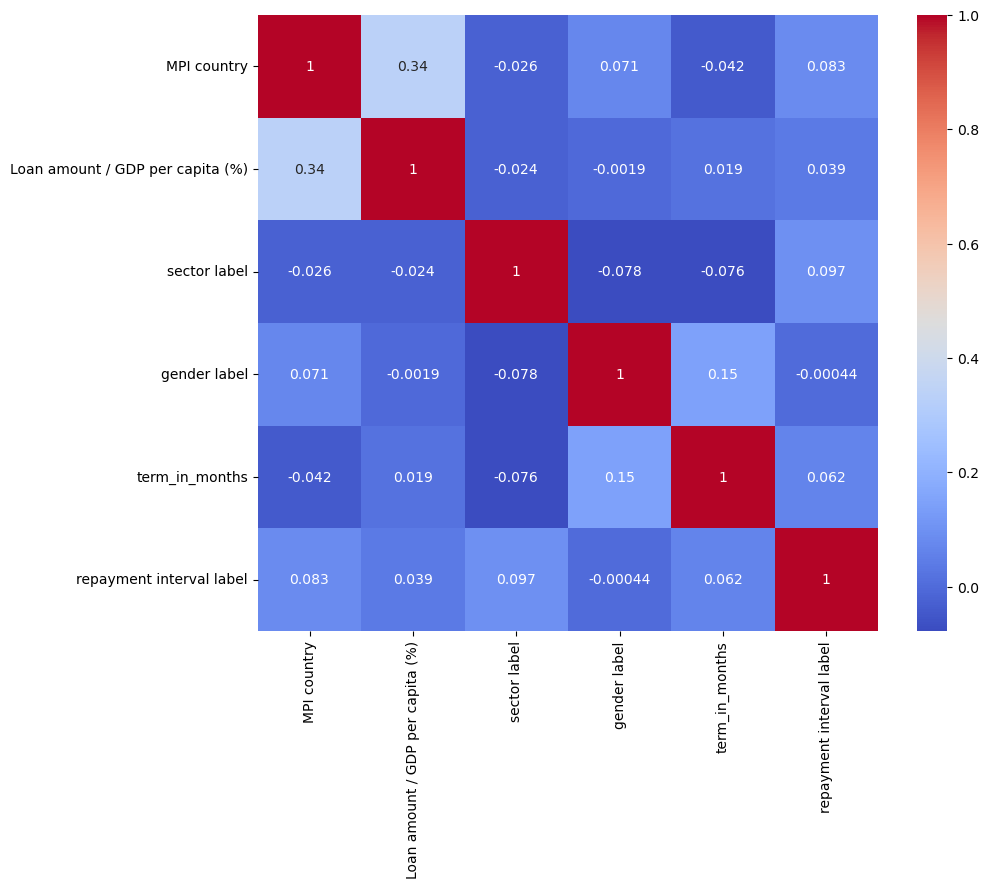

In [17]:
# Clustering
kvcol = ['MPI country', 'Loan amount / GDP per capita (%)', 'sector label', 'gender label' ,  'term_in_months', 'repayment interval label']
correlation = df[kvcol].corr()

plt.figure(figsize=(10,8))
sns.heatmap(correlation, annot=True, cmap='coolwarm')
plt.show()

In [18]:
# Fill missing values with median
fill_missing_values = SimpleImputer(strategy='median').fit(df[kvcol])
df[kvcol] = fill_missing_values.transform(df[kvcol]) 

In [19]:
col_cluster = ['MPI country', 'Loan amount / GDP per capita (%)', 'sector label', 'gender label', 'term_in_months', 'repayment interval label']
X = df[col_cluster]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [20]:
# Conducting PCA
pca = PCA(n_components='mle')
pca.fit(X_scaled)
print (pca.explained_variance_ratio_)
print (pca.n_components_)
print ("There is no need to conduct PCA!")

[0.22191578 0.20131688 0.1810052  0.14903207 0.13963881]
5
There is no need to conduct PCA!


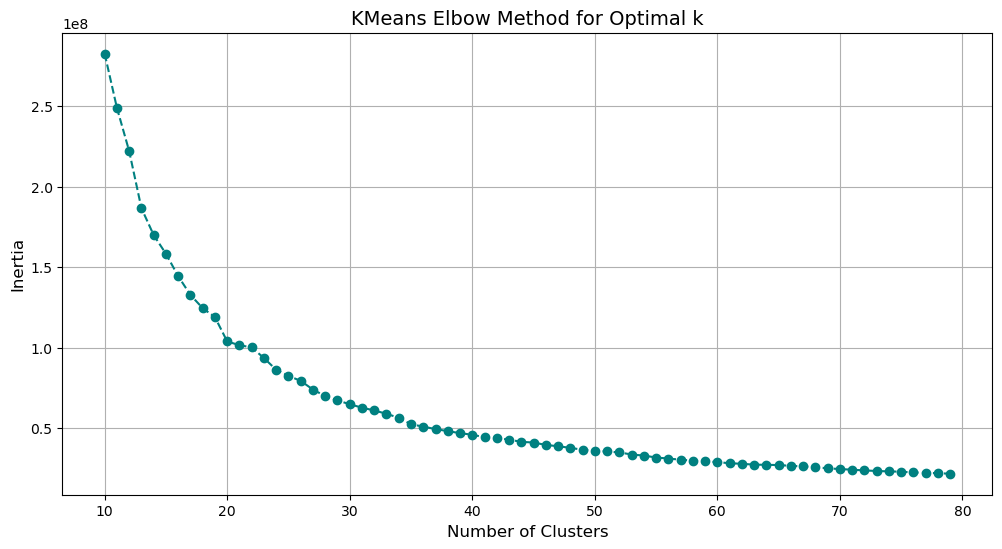

In [21]:
# Determining the optimal number of clusters for KMeans using the Elbow method
clusters = []
for i in range(10,80):
    kmeans = KMeans(n_clusters=i, random_state=0).fit(X)
    clusters.append(kmeans.inertia_)
plt.figure(figsize=(12,6))
plt.plot(range(10, 80), clusters, marker='o', linestyle='--', color='teal')
plt.xlabel('Number of Clusters', fontsize=12)
plt.ylabel('Inertia', fontsize=12)
plt.title('KMeans Elbow Method for Optimal k', fontsize=14)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid(True)
plt.show()

In [22]:
# Conducting KMeans clustering, with 50 clusters
kmeans = KMeans(n_clusters=50, random_state=1).fit(X)
labels = kmeans.labels_
clusters = kmeans.labels_.tolist()

df['Loan class'] = clusters

In [23]:
# Plot loans in each loan use group
# Plot 5 largest loan classes
cl_list = df['Loan class'].value_counts().index[0:5].tolist()

for i in cl_list :
    print('Loan class %d'%i)
    print( df[ df['Loan class'] == i][kvcol].describe() )
    print('- - - - - - - - - - - - - - - - - -  - - - - - - - - - - - - ')
    print('\n')

Loan class 33
        MPI country  Loan amount / GDP per capita (%)  sector label  \
count  71129.000000                      71129.000000  71129.000000   
mean       0.075923                          7.001255     10.669530   
std        0.063161                          2.244157      1.209648   
min        0.006000                          0.220215      6.000000   
25%        0.052000                          5.262411     10.000000   
50%        0.052000                          7.320276     11.000000   
75%        0.054000                          8.548645     11.000000   
max        0.557000                         11.318251     14.000000   

       gender label  term_in_months  repayment interval label  
count  71129.000000    71129.000000              71129.000000  
mean       0.148589        9.875128                  1.247213  
std        0.355686        3.174509                  0.593272  
min        0.000000        1.000000                  0.000000  
25%        0.000000       

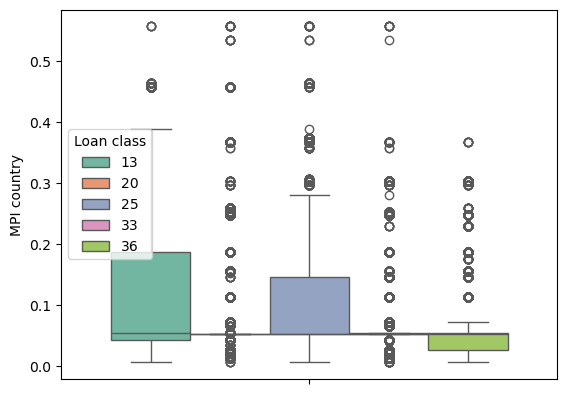

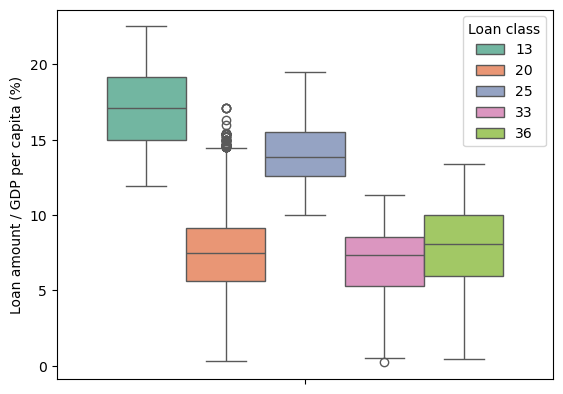

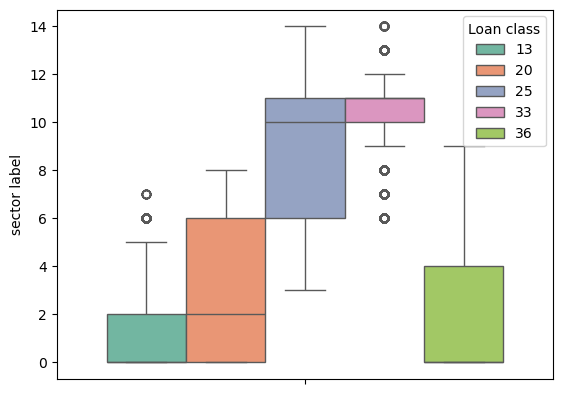

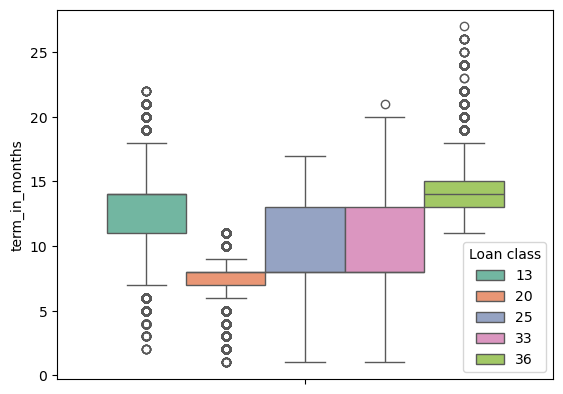

In [24]:
# Compare the differences among the five biggest clusters

for y in [ 'MPI country', 'Loan amount / GDP per capita (%)', 'sector label','term_in_months']:
    plt.figure()
    sns.boxplot(y= y, hue="Loan class",palette="Set2", data=df[ df['Loan class'].isin(df['Loan class'].value_counts().index[0:5].tolist())], legend=True);

<Axes: xlabel='count', ylabel='Loan class'>

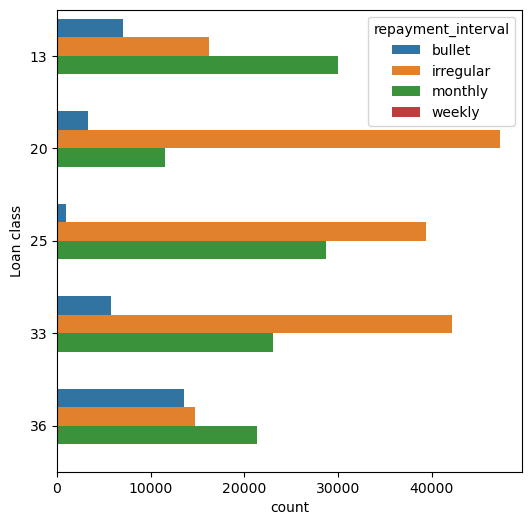

In [25]:
df['repayment_interval'] = df['repayment_interval'].astype('category') 
plt.figure(figsize=(6,6))
sns.countplot(y="Loan class", hue = 'repayment_interval',  data=df[ df['Loan class'].isin(df['Loan class'].value_counts().index[0:5].tolist())])

<Axes: xlabel='count', ylabel='Loan class'>

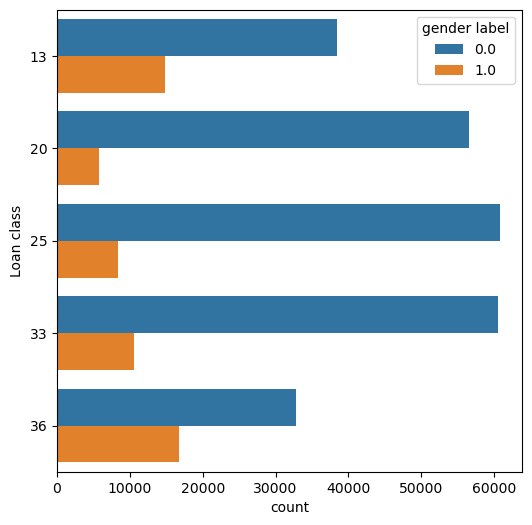

In [26]:
plt.figure(figsize=(6,6))
sns.countplot(y="Loan class", hue = 'gender label',  data=df[ df['Loan class'].isin(df['Loan class'].value_counts().index[0:5].tolist())])

In [27]:
# Get recommdation by determining the borrower's welfare assessment
df = df.reset_index(drop=True)
df.loc[ 0:1, : ]

,loan_amount,activity,sector,use,country_code,country,region,term_in_months,borrower_genders,repayment_interval,year,GDP_per_capita_USD,Loan amount / GDP per capita (%),MPI country,sector label,repayment interval label,gender label,Loan class
0,300.0,Fruits & Vegetables,Food,"To buy seasonal, fresh fruits to sell.",PK,Pakistan,Lahore,12.0,female,irregular,2014,1251.175719,23.977447,0.23,6.0,1.0,0.0,7
1,575.0,Rickshaw,Transportation,to repair and maintain the auto rickshaw used ...,PK,Pakistan,Lahore,11.0,female,irregular,2014,1251.175719,45.956774,0.23,13.0,1.0,0.0,17


In [28]:
loan_classes_predict = kmeans.predict( fill_missing_values.transform( df.loc[ 0:1, kvcol ]  ) )
print(loan_classes_predict)

for i in loan_classes_predict:
    print('Loan class %d'%i)
    print(df[ df['Loan class']== i][kvcol].describe())
    print('\n')

[ 7 17]
Loan class 7
        MPI country  Loan amount / GDP per capita (%)  sector label  \
count  47988.000000                      47988.000000  47988.000000   
mean       0.125633                         21.823296      9.695674   
std        0.098395                          2.632708      2.513272   
min        0.006000                         16.596836      4.000000   
25%        0.052000                         19.625779      6.000000   
50%        0.066000                         21.452231     11.000000   
75%        0.187000                         23.874521     11.000000   
max        0.557000                         28.648399     14.000000   

       gender label  term_in_months  repayment interval label  
count  47988.000000    47988.000000              47988.000000  
mean       0.161936       11.412478                  1.494624  
std        0.368396        3.362937                  0.551127  
min        0.000000        2.000000                  0.000000  
25%        0.000000

/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning:

X does not have valid feature names, but KMeans was fitted with feature names



In [29]:
# The predictions are relatively close to the actual conditions.